<a href="https://colab.research.google.com/github/tejas-1428/CodeClause/blob/main/Web_Traffic_time_series_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Task 3/webtraffic.csv')

In [5]:
data.shape

(4896, 2)

In [6]:
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


data Exploration for web Forcasting

In [9]:
import matplotlib.pyplot as plt
sessions = data['Sessions'].values

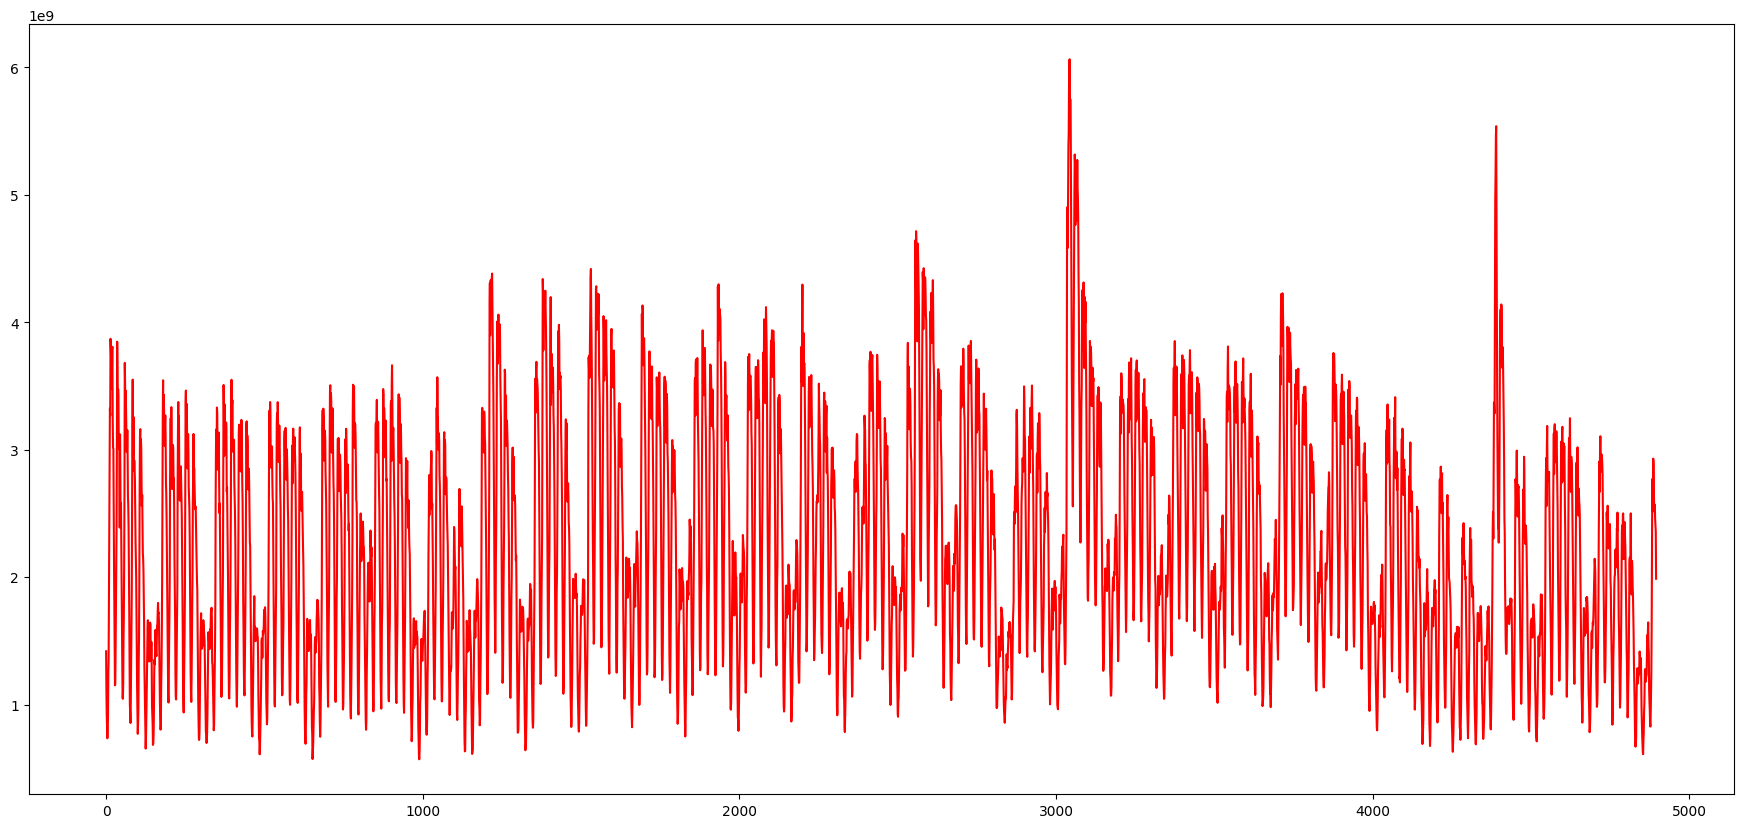

In [10]:
ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()


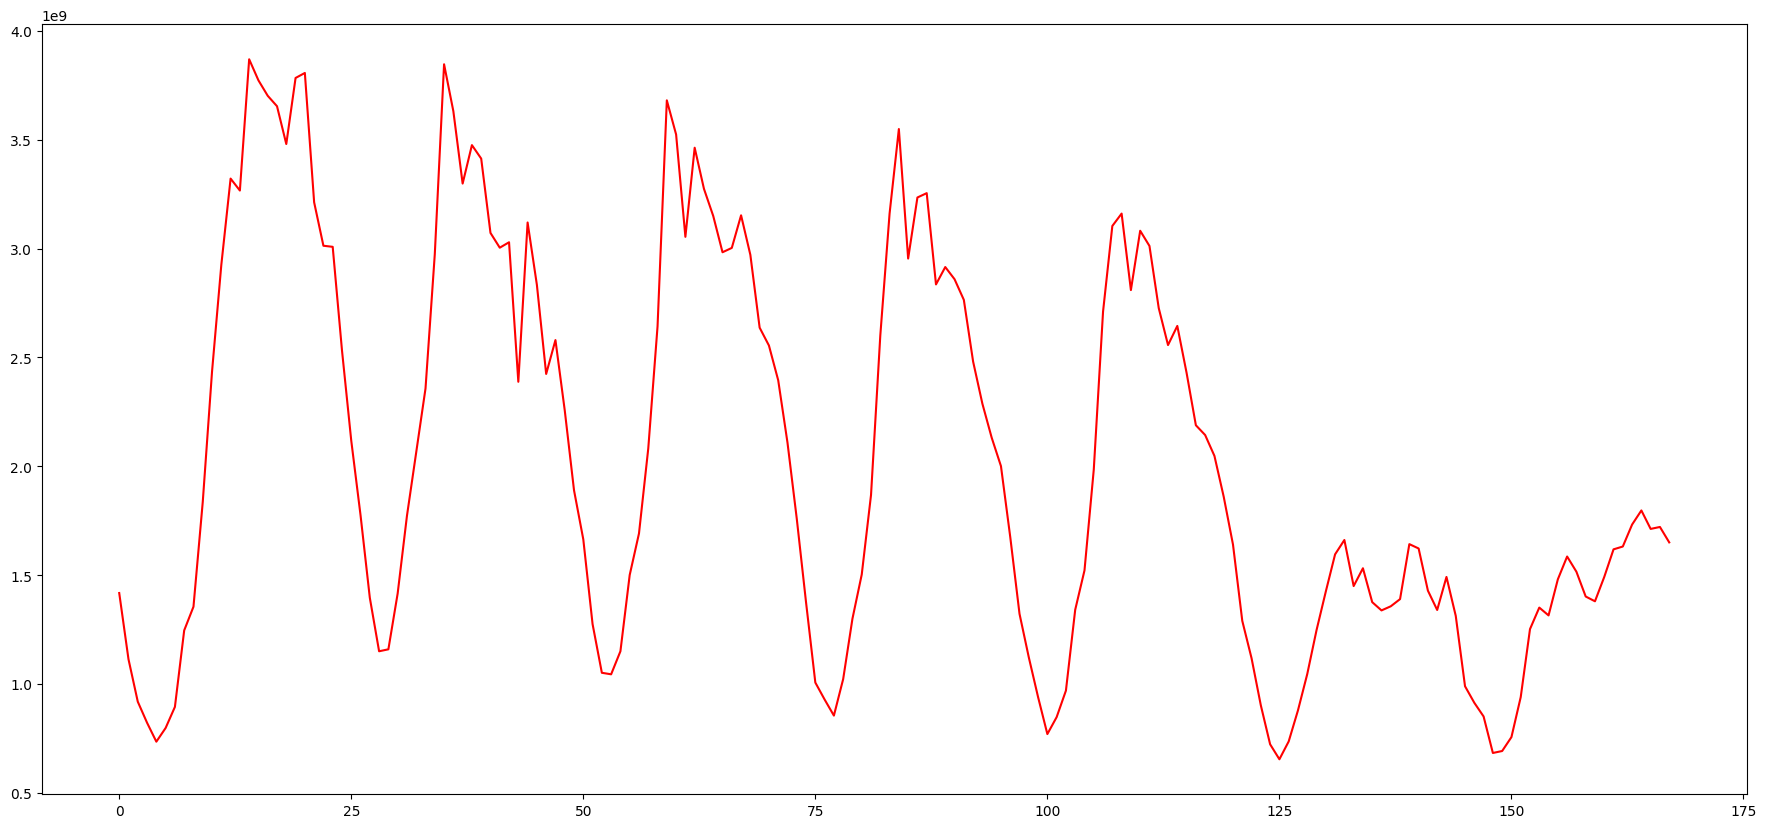

In [11]:
#first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

# Data Preparation for Web Traffic Forecasting

In [12]:
#let’s prepare the data for model training, here I have created input sequences, from the block traffic data.

def prepare_data(seq,num):
  x=[]
  y=[]
  for i in range(0,(len(seq)-num),1):

    input_ = seq[i:i+num]
    output  = seq[i+num]

    x.append(input_)
    y.append(output)

  return np.array(x), np.array(y)

In [13]:
#I have specified the sequence length of one week or 168 hours

num=168
x,y= prepare_data(sessions,num)
print(len(x))

4728


# Splitting the Dataset


In [14]:
#Next, I have split the data into a training set and validation set in the ratio, 90 is to 10. Now that sense it is a time serious problem, I have not splitted the data randomly, but in a sequential manner.

ind = int(0.9 * len(x))
x_tr = x[:ind]
y_tr = y[:ind]
x_val=x[ind:]
y_val=y[ind:]

In [15]:
from sklearn.preprocessing import StandardScaler
#normalizing the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

In [16]:
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

In [17]:
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

In [18]:
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_tr.shape)

(4255, 168, 1)


# Model Building for Web Traffic Forecasting

In [19]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras

In [20]:
model =  Sequential()
model.add(LSTM(128,input_shape=(168,1)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74881 (292.50 KB)
Trainable params: 74881 (292.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.compile(loss='mse',optimizer='adam')

In [24]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')

In [25]:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1494
Epoch 1: val_loss improved from inf to 0.03454, saving model to best_model.hdf5
133/133 [==============================] - 46s 319ms/step - loss: 0.1494 - val_loss: 0.0345
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - ETA: 0s - loss: 0.0401
Epoch 2: val_loss improved from 0.03454 to 0.02709, saving model to best_model.hdf5
133/133 [==============================] - 37s 280ms/step - loss: 0.0401 - val_loss: 0.0271
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0357
Epoch 3: val_loss improved from 0.02709 to 0.02621, saving model to best_model.hdf5
133/133 [==============================] - 32s 238ms/step - loss: 0.0357 - val_loss: 0.0262
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0336
Epoch 4: val_loss did not improve from 0.02621
133/133 [==============================] - 35s 260ms/step - loss: 0.0336 - val_loss: 0.0339
Epoch 5/30
133/133 [==============================] - ETA: 0s - loss: 0.0303
Epoch 5: val_loss did not improve from 0.02621
133/133 [==============================] - 31s 232ms/step - loss: 0.0303 - val_loss: 0.0296
Epoch 6/30
133/133 [==============================] - ETA: 0s - loss: 0.0

In [27]:
model.load_weights('best_model.hdf5')

# Baseline Model with Forecasting

In [28]:
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

In [29]:
x_reshaped = x_val.reshape(-1,168)

In [30]:
y_pred = compute_moving_average(x_reshaped)

In [32]:
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean square of error:- ",mse)

Mean square of error:-  0.5546025834434455


# Web Traffic Forecasting

In [33]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]
  #intialize the array with a weeks data
  temp=x_val[ind]
  for i in range(no_of_pred):
    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]

    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)
    #ignore the first element of array
    temp = temp[1:]
  return predictions

In [34]:
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)
y_true = y_val[ind:ind+(no_of_pred)]

1/1 [==============================] - 0s 33ms/step


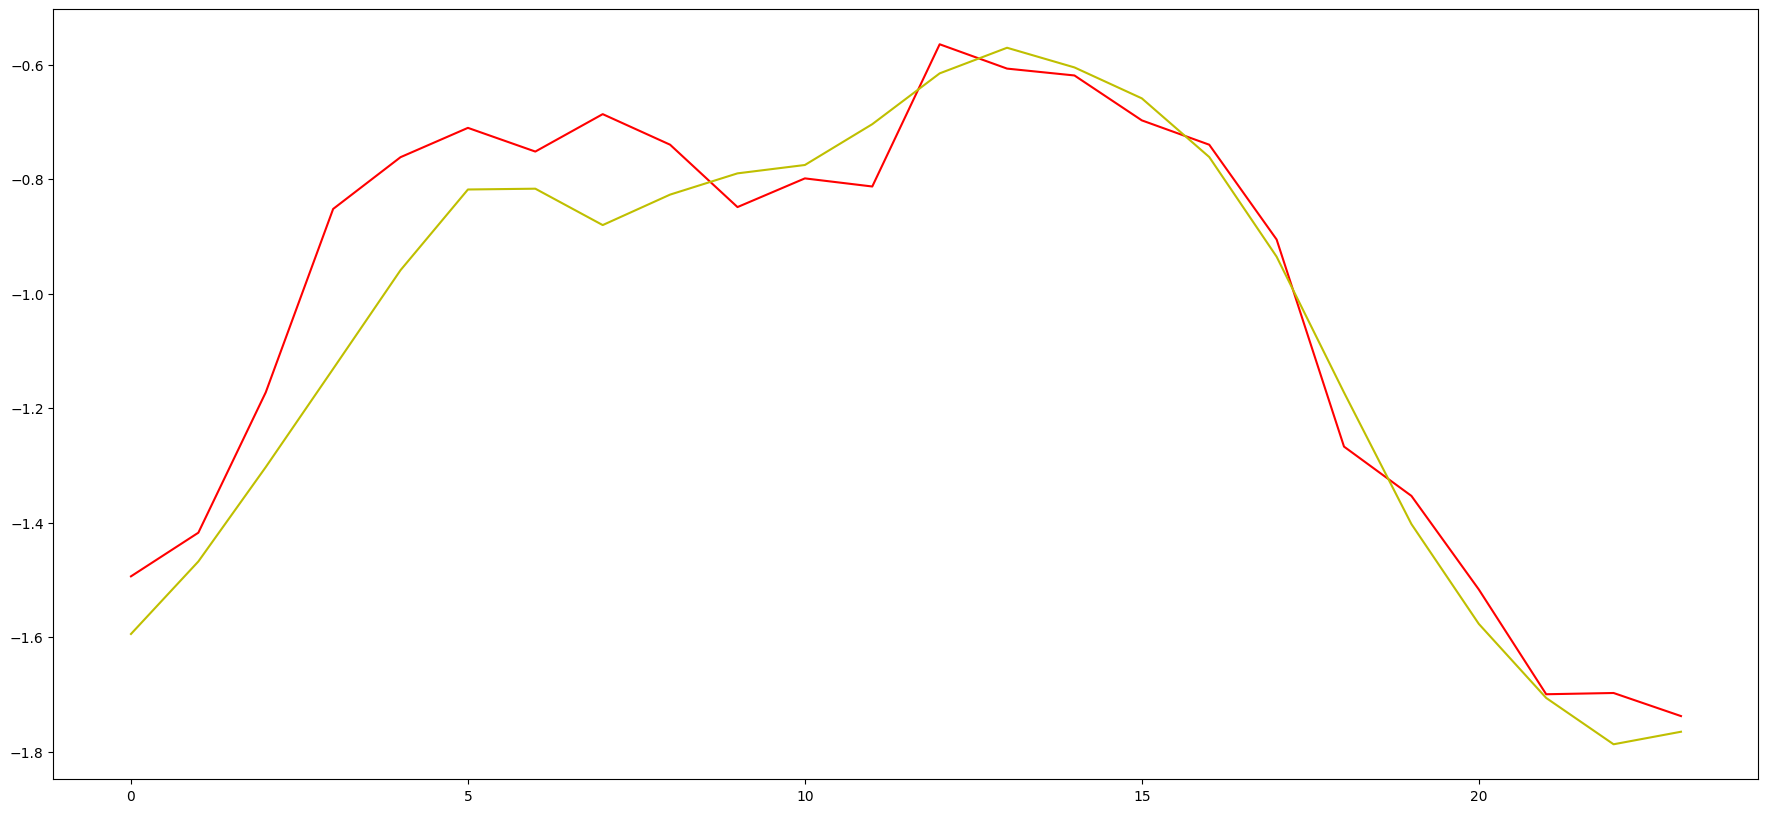

In [35]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()
plot(y_true,y_pred)